In [1]:
from datetime import datetime
import numpy as np             #for numerical computations like log,exp,sqrt etc
import pandas as pd            #for reading & storing data, pre-processing
import matplotlib.pylab as plt #for visualization
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
import datetime
# import FinanceDataReader as fdr
# pip install finance-datareader

import warnings
rcParams['figure.figsize'] = 6, 6

In [2]:
AAPL = pd.read_excel('/Users/minjaejo/OneDrive - SNU/Server/GAN/QGAN/QGAN_2_NumpyDiscri/Src/AAPL.xlsx')
MSFT = pd.read_excel('/Users/minjaejo/OneDrive - SNU/Server/GAN/QGAN/QGAN_2_NumpyDiscri/Src/MSFT.xlsx')
AAPL = AAPL.set_index('Date')
MSFT = MSFT.set_index('Date')
# AAPL = fdr.DataReader('AAPL', start='2010-01-01', end='2018-01-01') # Apple
# MSFT = fdr.DataReader('MSFT', start='2010-01-01', end='2018-01-01') # Microsoft

In [3]:
AAPL = AAPL[['Close']]
MSFT = MSFT[['Close']]
df1 = AAPL.pct_change(1).iloc[1:]
df1 = df1.rename(columns={'Close':'Return'})
df2 = MSFT.pct_change(1).iloc[1:]
df2 = df2.rename(columns={'Close':'Return'})
merge_inner = pd.merge(df1, df2, on="Date")

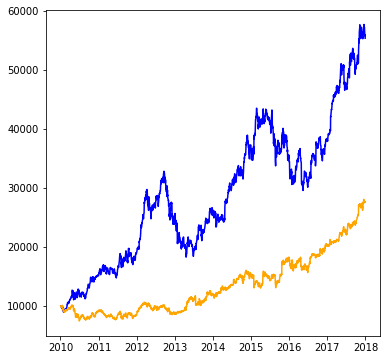

In [4]:
plt.plot(AAPL/AAPL.iloc[0]*10000, color = "blue")
plt.plot(MSFT/MSFT.iloc[0]*10000, color = "orange")

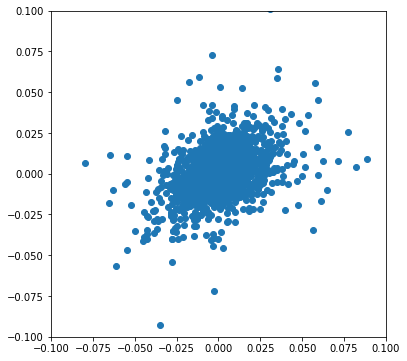

In [5]:
# Return data
Return_X = np.array(merge_inner[['Return_x']].iloc[:,0])
Return_Y = np.array(merge_inner[['Return_y']].iloc[:,0])
plt.xlim([-0.1, 0.1])
plt.ylim([-0.1, 0.1])
plt.scatter(Return_X, Return_Y)

In [6]:
# Copula data
from statsmodels.distributions.empirical_distribution import ECDF
ecdf_x = ECDF(np.array(merge_inner['Return_x']))
ecdf_y = ECDF(np.array(merge_inner['Return_y']))
X_pit = ecdf_x(merge_inner['Return_x'])
Y_pit = ecdf_y(merge_inner['Return_y'])


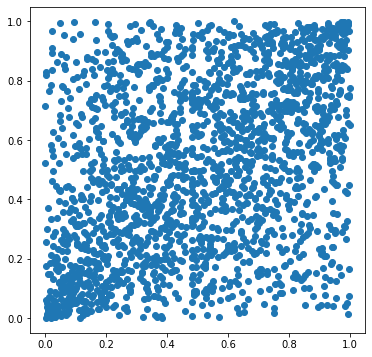

In [7]:
plt.scatter(X_pit, Y_pit)

In [8]:
import numpy as np
seed = 71
np.random.seed = seed

import matplotlib.pyplot as plt
%matplotlib inline

from qiskit import QuantumRegister, QuantumCircuit, BasicAer
from qiskit.circuit.library import TwoLocal, UniformDistribution, NormalDistribution

from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.algorithms import NumPyDiscriminator, QGAN, PyTorchDiscriminator

algorithm_globals.random_seed = seed

In [9]:
n=2
real_data = np.vstack((X_pit*(2**n), Y_pit*(2**n))).T
discretised_real_data = np.trunc(real_data)

bounds_x = [0., 2**n-1] 
bounds_y = [0., 2**n-1]
num_qubits = [n, n]

In [10]:
def ansatz_QGAN(params, n):
    qc = QuantumCircuit(n)

    for i in range(3*n):
        if(i<n): qc.rz(params[i], i)
        elif(i<2*n): qc.rx(params[i], i%n)
        else: qc.rz(params[i], i%n)
    
    for i in range(n):
        qc.cx(i, (i+1)%n)
        # qc.rx(2*params[i+3*n],i)
        qc.rx(2*params[i+3*n],(i+1)%n)
        qc.cx(i, (i+1)%n)

    
    gate = qc.to_gate()
    gate.name = "Ansatz"

    return gate

In [11]:
from qiskit.algorithms.optimizers import SPSA
from qiskit.circuit import ParameterVector
num_epochs = 500

# Batch size
batch_size = 100
# batch_size = int(len(X_pit))

# # Initialize qGAN
# qgan = QGAN(real_data, [bounds_x, bounds_y], num_qubits, batch_size, num_epochs, snapshot_dir=None)
qgan = QGAN(discretised_real_data, [bounds_x, bounds_y], num_qubits, batch_size, num_epochs, snapshot_dir=None)
qgan.seed = 71
# Set quantum instance to run the quantum generator
quantum_instance = QuantumInstance(backend=BasicAer.get_backend('statevector_simulator'),
                                   seed_transpiler=seed, seed_simulator=seed)

number_of_parameters = 2*n*4
theta = ParameterVector('theta', number_of_parameters)
ansatz = QuantumCircuit(num_qubits[0]+num_qubits[1])
ansatz.h(range(num_qubits[0]))
for ii in range(num_qubits[0]):
    ansatz.cx(ii, ii+num_qubits[0])
ansatz.append(ansatz_QGAN(theta[:int(number_of_parameters/2)], num_qubits[0]), range(n))
ansatz.append(ansatz_QGAN(theta[int(number_of_parameters/2):number_of_parameters], num_qubits[1]), range(n, int(2*n)))
init_params = np.random.rand(number_of_parameters) * 2 * np.pi

g_circuit = ansatz


# Set quantum generator
optimiser = SPSA(maxiter=1)
# qgan.set_generator(generator_circuit=g_circuit, generator_init_params=init_params, generator_optimizer=optimiser)
qgan.set_generator(generator_circuit=g_circuit, generator_init_params=init_params)
# The parameters have an order issue that following is a temp. workaround
qgan._generator._free_parameters = sorted(g_circuit.parameters, key=lambda p: p.name)

# Set classical discriminator neural network
discriminator = PyTorchDiscriminator(len(num_qubits))
# discriminator = NumPyDiscriminator(len(num_qubits))
qgan.set_discriminator(discriminator)



/Users/minjaejo/opt/anaconda3/envs/IBM/lib/python3.9/site-packages/sympy/core/expr.py:3949: SymPyDeprecationWarning: 

expr_free_symbols method has been deprecated since SymPy 1.9. See
https://github.com/sympy/sympy/issues/21494 for more info.

  SymPyDeprecationWarning(feature="expr_free_symbols method",


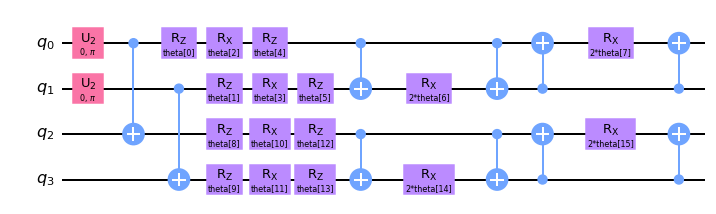

In [12]:
ansatz.decompose().draw('mpl')
# ansatz.num_parameters
# number_of_parameters

In [13]:
# Run qGAN for "number_of_trial" runs and find the best trial with the minimum relative entropy
result_set = {}
number_of_trial = 2
for trial in range(number_of_trial):
    init_params = np.random.rand(number_of_parameters) * 2 * np.pi
    qgan.set_generator(generator_circuit=g_circuit, generator_init_params=init_params)
    result = qgan.run(quantum_instance)
    result_set[trial] = [result['params_g'], result['rel_entr']]
    print(trial, result['rel_entr'])
    trial += 1
    
minimum_relative_entropy_trial = 0
for trial in range(number_of_trial):
    if(result_set[trial][1] < result_set[minimum_relative_entropy_trial][1]): 
        minimum_relative_entropy_trial = trial    

qgan.set_generator(generator_circuit=g_circuit, generator_init_params=result_set[minimum_relative_entropy_trial][0])
result = qgan.run(quantum_instance)

0 0.0733
1 0.0557


In [14]:
print('Training results:')
for key, value in result.items():
    print(key, value)

Training results:
params_d [array([[ 0.45797944, -0.30484334],
       [ 0.06438979, -0.1608302 ],
       [ 0.4786534 ,  0.11839304],
       ...,
       [ 0.1436549 ,  0.20050977],
       [-0.6069243 ,  0.43609437],
       [-0.13511638,  0.6424832 ]], dtype=float32), array([ 2.08794206e-01, -5.00737846e-01,  3.99313122e-01,  2.10627437e-01,
       -6.50796771e-01, -1.55420065e-01, -2.11590841e-01, -3.35392773e-01,
       -3.29953790e-01,  1.11352548e-01,  1.79756265e-02, -3.21834266e-01,
       -6.93140805e-01,  5.70109487e-01, -5.93504012e-02, -1.91734955e-01,
        1.96633160e-01, -5.75291753e-01, -5.83870471e-01, -3.94872963e-01,
        6.05944633e-01, -4.01733816e-01, -2.71625668e-01, -1.55053228e-01,
        1.52793869e-01, -6.19666636e-01,  2.99299151e-01,  4.77082282e-01,
       -6.84690595e-01, -1.60669848e-01,  6.71232820e-01,  3.20139199e-01,
        6.19194388e-01,  6.94416702e-01,  4.55071002e-01,  4.44298416e-01,
        2.66470641e-01, -6.43487811e-01, -1.32692745e-03, 

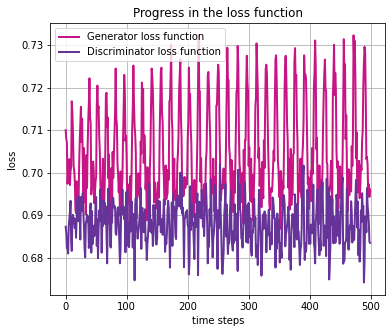

In [15]:
# Plot progress w.r.t the generator's and the discriminator's loss function
initial = num_epochs*minimum_relative_entropy_trial
final = num_epochs*(minimum_relative_entropy_trial+1)
t_steps = np.arange(num_epochs)
plt.figure(figsize=(6, 5))
plt.title("Progress in the loss function")
plt.plot(t_steps, qgan.g_loss[initial:final], label="Generator loss function", color="mediumvioletred", linewidth=2)
plt.plot(t_steps, qgan.d_loss[initial:final], label="Discriminator loss function", color="rebeccapurple", linewidth=2)
plt.grid()
plt.legend(loc="best")
plt.xlabel("time steps")
plt.ylabel("loss")
plt.show()

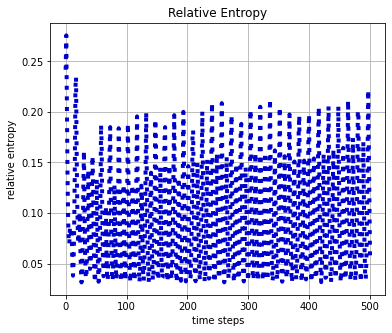

In [16]:
# Plot progress w.r.t relative entropy
plt.figure(figsize=(6,5))
plt.title('Relative Entropy')
plt.plot(np.linspace(0, num_epochs, len(qgan.rel_entr[initial:final])), qgan.rel_entr[initial:final], color='mediumblue', lw=4, ls=':')
plt.grid()
plt.xlabel('time steps')
plt.ylabel('relative entropy')
plt.show()

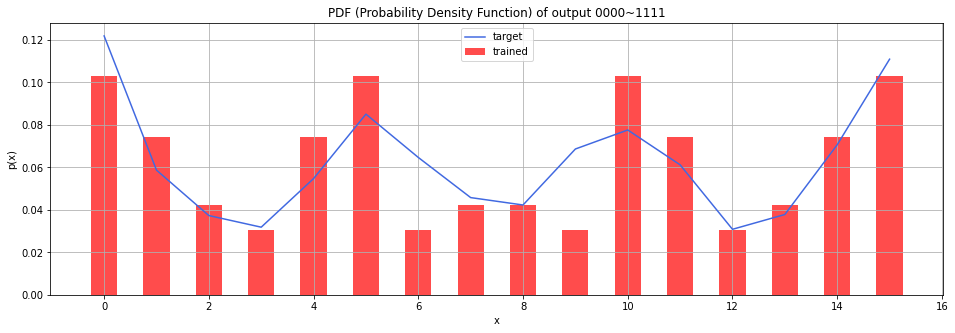

In [17]:
samples_g, prob_g = qgan.generator.get_output(qgan.quantum_instance, shots=10**4)

prob_g = np.array(prob_g).reshape(2**n,2**n).T

temp = []
for i in range(int(bounds_x[1] + 1)):
    for j in range(int(bounds_y[1] + 1)):
        freq = 0
        for k in range(len(discretised_real_data)):
            if(discretised_real_data[k][0]==i and discretised_real_data[k][1]==j):
                freq += 1
        temp.append(freq)        
discretised_real_data_dist = np.array(temp) / sum(temp)
discretised_real_data_dist = discretised_real_data_dist.reshape(2**n,2**n)
plt.figure(figsize=(16, 5))
plt.title("PDF (Probability Density Function) of output 0000~1111")
plt.plot(discretised_real_data_dist.reshape(-1), color="royalblue", label="target")
plt.bar(range(2**(2*n)), prob_g.reshape(-1), alpha=0.7,  width=0.5, color="red", label="trained")
plt.grid()
plt.xlabel("x")
plt.ylabel("p(x)")
plt.legend(loc="best")

In [23]:


m=2**num_qubits[0]
inds=np.random.choice(np.arange(m**2), p=prob_g.reshape(-1), size=2000, replace=True)
sampling = np.array([inds//m, inds%m]).T


# Kolmogorov-Smironov Test
from ndtest import *
print(ks2d2s(discretised_real_data.T[0], discretised_real_data.T[1], sampling.T[0], sampling.T[1]))

(0.15582686177195026, 0.04317196819085485) (1.0, 0.0004970178926441351)


In [79]:
# number_of_sampling_from_QGAN = 10**4
# samples_g, prob_g = qgan.generator.get_output(qgan.quantum_instance, shots=number_of_sampling_from_QGAN)
# # m=2**num_qubits[0]
# # dist = np.reshape(prob_g, (m, m)).T

# prob_g = np.array(prob_g).reshape(2**n,2**n).T
# m=2**num_qubits[0]
# inds=np.random.choice(np.arange(m**2), p=prob_g.reshape(-1), size=number_of_sampling_from_QGAN, replace=True)
# sampling = np.array([inds//m, inds%m]).T

# samples_g_1d = np.unique(np.array(samples_g).T)

# prob_1d_x = np.array(prob_g).sum(axis = 1)
# prob_1d_y = np.array(prob_g).sum(axis = 0)


# plt.figure(figsize=(16, 5))
# plt.subplot(1, 2, 1)
# plt.title("PDF (Probability Density Function) of x coordinate")
# plt.hist(sampling.T[0], density=True, alpha=0.7, color='royalblue', width=0.5, label='trained', bins=np.arange(-1/2**n, 2**n+1, 1))
# plt.hist(discretised_real_data.T[0], density=True, color="deepskyblue", alpha=0.7, width=0.5, label='target', bins=np.arange(0, 2**n+1, 1))
# # plt.plot(real_data_x_PDF, '-o', label='target', color='deepskyblue', linewidth=4, markersize=12)
# # plt.bar(samples_g_1d,  prob_1d_x, color='royalblue', width=0.8, label='trained')
# plt.grid()
# plt.xlabel("x")
# plt.ylabel("p(x)")
# plt.legend(loc="best")

# plt.subplot(1, 2, 2)
# plt.title("PDF (Probability Density Function) of y coordinate")
# plt.hist(sampling.T[1], density=True, alpha=0.7, color='royalblue', width=0.5, label='trained', bins=np.arange(-1/2**n, 2**n+1, 1))
# plt.hist(discretised_real_data.T[1], density=True, color="deepskyblue", alpha=0.7, width=0.5, label='target', bins=np.arange(0, 2**n+1, 1))
# plt.grid()
# plt.xlabel("x")
# plt.ylabel("p(x)")
# plt.legend(loc="best")
# plt.show()


In [ ]:
# import seaborn as sns
# import numpy as np
# import pandas as pd
# from scipy.stats import norm



# axs = sns.jointplot(real_data.T[0], real_data.T[1])
# axs.ax_joint.scatter(real_data.T[0], real_data.T[1], c='r')

# axs.ax_marg_x.cla()
# axs.ax_marg_y.cla()
# sns.distplot(sampling.T[0], ax=axs.ax_marg_x)
# sns.distplot(real_data.T[0], ax=axs.ax_marg_x)
# sns.distplot(sampling.T[1], ax=axs.ax_marg_y, vertical=True)
# sns.distplot(real_data.T[1], ax=axs.ax_marg_y, vertical=True)


In [70]:
# X_pit_QGAN = [sampling[i][0]/(2**n)+np.random.uniform(low=0.0, high=1.0)/(2**n) for i in range(number_of_sampling_from_QGAN)]
# Y_pit_QGAN = [sampling[i][1]/(2**n)+np.random.uniform(low=0.0, high=1.0)/(2**n) for i in range(number_of_sampling_from_QGAN)]
# plt.scatter(X_pit_QGAN, Y_pit_QGAN)

In [71]:
# Return_X_QGAN = np.quantile(merge_inner['Return_x'], q=X_pit_QGAN)
# Return_Y_QGAN = np.quantile(merge_inner['Return_y'], q=Y_pit_QGAN)
# plt.scatter(Return_X_QGAN, Return_Y_QGAN)
# plt.scatter(Return_X, Return_Y)

In [73]:
# from ndtest import *
# ks2d2s(Return_X, Return_Y, Return_X_QGAN, Return_Y_QGAN)

In [72]:
# Return_X_QGAN = np.quantile(merge_inner['Return_x'], q=X_pit_QGAN)
# Return_Y_QGAN = np.quantile(merge_inner['Return_y'], q=Y_pit_QGAN)

# X_pit_uniform = [np.random.uniform(low=0.0, high=1.0) for i in range(n*40)]
# Y_pit_uniform = [np.random.uniform(low=0.0, high=1.0) for i in range(n*40)]

# X_pit_uniform = np.quantile(merge_inner['Return_x'], q=X_pit_uniform)
# Y_pit_uniform = np.quantile(merge_inner['Return_y'], q=Y_pit_uniform)


# print(ks2d2s(Return_X[:2000], Return_Y[:2000], Return_X_QGAN[:2000], Return_Y_QGAN[:2000]), 
#     ks2d2s(Return_X[:2000], Return_Y[:2000], Return_X[:2000], Return_Y[:2000]),
#     ks2d2s(Return_X[:2000], Return_Y[:2000], X_pit_uniform[:2000], Y_pit_uniform[:2000]))